In [3]:
import numpy as np
import pandas as pd
from pyproj import Geod
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
train_data = pd.read_csv( "train.csv" )
test_data = pd.read_csv( "test.csv" )

In [5]:
# Utiliy functions

#Get distance between pairs of lat-lon points
wgs84_geod = Geod(ellps='WGS84')
def get_distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

# Convert time object to seconds
def to_seconds(time):
    return (time.hour * 60 + time.minute) * 60 + time.second

In [6]:
def normalize(data):
    return ((data - data.min()) / (data.max() - data.min()))

def process_data(data):
    # Calculating distance (km) based on longitude/latituides and adding it in a new column 'dist'
    data['dist'] = get_distance(data['pickup_latitude'].tolist(), data['pickup_longitude'].tolist(),
                                data['dropoff_latitude'].tolist(), data['dropoff_longitude'].tolist())
    
    data['dist'] = data['dist'] / 1000
#     data['dist'] = data['dist']**2
    
    # Replacing N of store_and_fwd_flag with 0 and Y with 1
    data = data.replace({'N': 0, 'Y': 1})

    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])    
    data['pickup_day_of_week'] = data.pickup_datetime.dt.weekday
    data['pickup_day_of_month'] = data.pickup_datetime.dt.days_in_month
    data['pickup_month'] = data.pickup_datetime.dt.month
    data['pickup_hour'] = data.pickup_datetime.dt.hour
    data['pickup_min'] = data.pickup_datetime.dt.minute
#     data['is_weekend'] = data.pickup_day_of_week.map(lambda x: 1 if x >= 5 else 0)
#     data['is_night_time'] = [1 if (i==0 or i>=19)  else 0 for i in data['pickup_hour']]
    
#     data['pickup_latitude'] = data['pickup_latitude']**2
#     data['pickup_longitude'] = data['pickup_longitude']**2
#     data['dropoff_longitude'] = data['dropoff_longitude']**2
#     data['dropoff_latitude'] = data['dropoff_latitude']**2
    
    # Dropping columns no longer required
    data = data.drop([ 'pickup_latitude', 'pickup_longitude', 'pickup_datetime',
                       'dropoff_latitude','dropoff_longitude', 'id'], axis=1)


#     data = data.drop(['pickup_datetime', 'id'], axis=1)
            
    return data

In [7]:
# Hypothesis function
def hyp(theta, X):
    return np.dot(X, theta.T)  

# The loss function in our case is the sum of the squared error
def loss_func(theta, X, Y):
    return np.sum(((hyp(theta, X) - Y)**2) / (2 * X.shape[0]))

def get_gradient(theta, X, Y):
    derivatives = []
  
    for i in range(0, X.shape[1]):
        derivatives.append(np.sum((hyp(theta, X) - Y) * X[:, i]) / X.shape[0])

    return np.array(derivatives)

def gradient_descent(X, Y, maxniter=20000):
    thetas = np.random.rand(X.shape[1],)
    alpha = 0.001
    costs = []
    
    for i in range(0, maxniter):
        thetas = thetas - (alpha * get_gradient(thetas, X, Y))
        costs.append(loss_func(thetas, X, Y))
        
    return thetas, costs

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
D:\Applications\Python\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


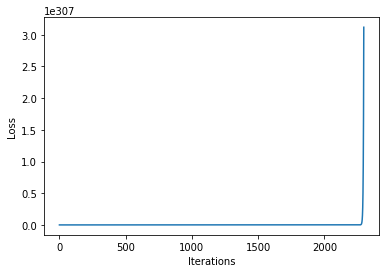

In [8]:
proc_data = process_data(train_data)
# proc_data = proc_data[(proc_data['trip_duration'] >= 120) & (proc_data['trip_duration'] <= 3000)]
# proc_data = proc_data[proc_data.trip_duration <= np.percentile(proc_data.trip_duration, 99)]
# proc_data = proc_data[proc_data.dist <= np.percentile(proc_data.dist, 98)]
X = proc_data.drop('trip_duration', axis=1).values
Y = proc_data['trip_duration'].values

max_iters = 5000
thetas, costs = gradient_descent(X, Y, max_iters)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(np.arange(0, max_iters), costs)

In [101]:
proc_data = process_data(train_data)
proc_data.dtypes

vendor_id                int64
passenger_count          int64
store_and_fwd_flag       int64
trip_duration            int64
dist                   float64
pickup_day_of_week       int64
pickup_day_of_month      int64
pickup_month             int64
pickup_hour              int64
pickup_min               int64
dtype: object

In [98]:
pred = hyp(thetas, process_data(test_data))

submission = pd.DataFrame({'id':test_data['id'],'trip_duration':pred})
submission.to_csv("submission.csv", index=False)

print(pd.DataFrame(pred).describe())
print(submission)

                  0
count  30000.000000
mean     965.206554
std      528.899915
min      321.490885
25%      672.157737
50%      802.555303
75%     1041.719432
max     7909.361168
              id  trip_duration
0      id1430318     842.926369
1      id3276964     727.816390
2      id2541342    1119.064933
3      id3582288     561.453948
4      id2976277     428.129761
5      id1856113     854.457445
6      id0712136     883.606233
7      id2704634     908.610295
8      id2736446     519.318796
9      id3267520    1100.796929
10     id2060082     930.207033
11     id0668631     753.896162
12     id3972794    1072.114822
13     id3610505    1302.093831
14     id1129765     607.210100
15     id0846002     725.974250
16     id2738706    1196.907658
17     id0077153     531.327100
18     id0096075     641.217361
19     id1543517     916.996485
20     id1557821     861.804553
21     id1453667     823.068973
22     id3968862     597.780357
23     id3810234     786.421571
24     id2796384    

count  30000.000000
mean     951.616440
std      551.389681
min      266.693274
25%      634.700283
50%      808.378487
75%     1046.484861
max     8028.482600

In [ ]:
# Removing outliers

# 1-
# temp = train_data[train_data.trip_duration <= np.percentile(train_data.trip_duration, 99)]

# 2-
# temp = process_data(train_data)
# temp = temp[(temp['trip_duration'] >= 120) & (temp['trip_duration'] <= 3000)]
# temp = temp[(temp['dist'] > 0)]
# temp = temp[temp.dist <= np.percentile(temp.dist, 98)]

# print(temp.passenger_count.describe())

# print(temp.trip_duration.describe())

# fig, ax = plt.subplots()
# sns.distplot(temp['trip_duration'], hist=False, rug=True)
# sns.distplot(temp['dist'], hist=False, rug=True)